# **Library**

In [1]:
# conda env create -f ENV.yml && conda activate car-segment
import importlib

In [2]:
import numpy as np
import os
import torch
import matplotlib.pyplot as plt
import cv2
import math
import random
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image

In [4]:
import urllib

def maybe_download_sam():
    model_path = "saved_models/sam_vit_h_4b8939.pth"
    if not os.path.exists(model_path):
        print("Downloading SAM model...")
        urllib.request.urlretrieve("https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth", model_path)
    else:
        print("SAM model already downloaded.")


# **SAM**

SAM model already downloaded.


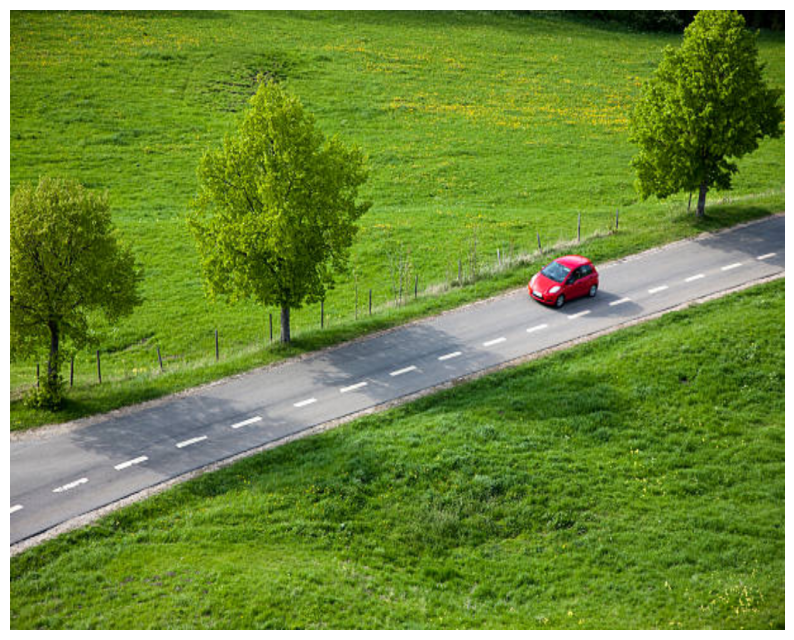

In [13]:
maybe_download_sam()
# Path to your image file
image_path = './images/Car_3.jpg'

# Load and display the image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (0, 0), fx = 1000/image.shape[1], fy = 800/image.shape[0])

plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('off')
plt.show()

In [14]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "./saved_models/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

39
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


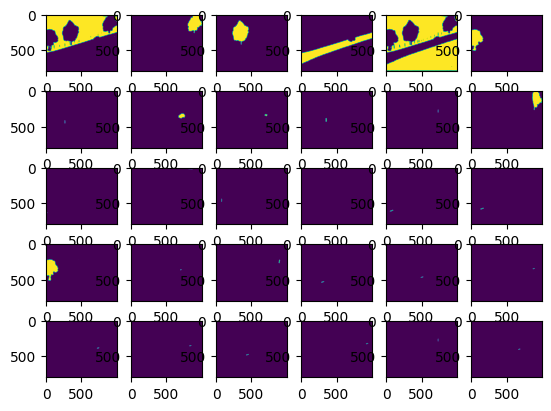

In [15]:
masks = mask_generator.generate(image)
print(len(masks))
print(masks[0].keys())
for i in range(30):
  plt.subplot(5,6,i+1)
  plt.imshow(masks[i+1]["segmentation"])

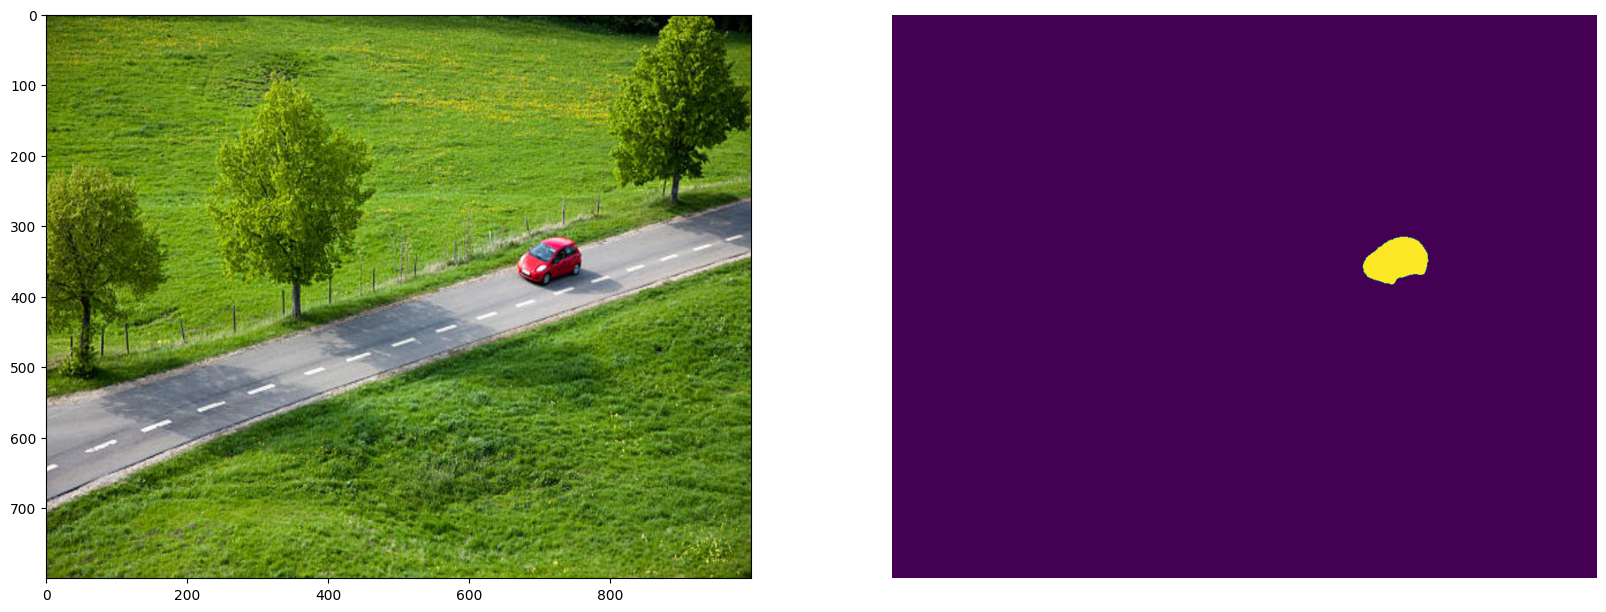

[668, 316, 92, 67]


In [16]:
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(image)

idx = 8
plt.subplot(1,2,2)
plt.imshow(masks[idx]["segmentation"])
plt.axis('off')
plt.show()
image.shape
print(masks[idx]["bbox"])

In [17]:
#for all masks
mask_list=[]
for i in range(len(masks)):
  mask_list.append(masks[i]["segmentation"])


seg_obj_list=[]
for mask in mask_list:

  pixel_list=[]
  for i in range(len(image)):
    for j in range (len(image[i])):
      if(mask[i][j]==False):
        pixel_list.append([255,255,255])
      else:
        pixel_list.append(image[i][j])

  segmented_obj = np.array(pixel_list).reshape(len(image),len(image[0]),3)
  seg_obj_list.append(segmented_obj)

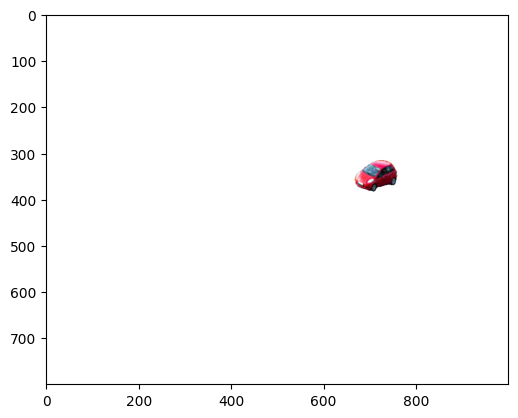

In [18]:
plt.imshow(seg_obj_list[8])

# **Missing-pixel-filler**

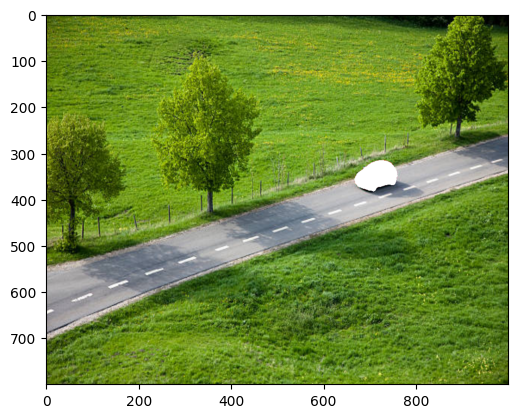

In [19]:
car_mask = masks[8]["segmentation"]
pixel_list=[]
for i in range(len(image)):
  for j in range (len(image[i])):
    if(car_mask[i][j]==True):
      pixel_list.append([255,255,255])
    else:
      pixel_list.append(image[i][j])

segmented_obj = np.array(pixel_list).reshape(len(image),len(image[0]),3)
plt.imshow(segmented_obj)

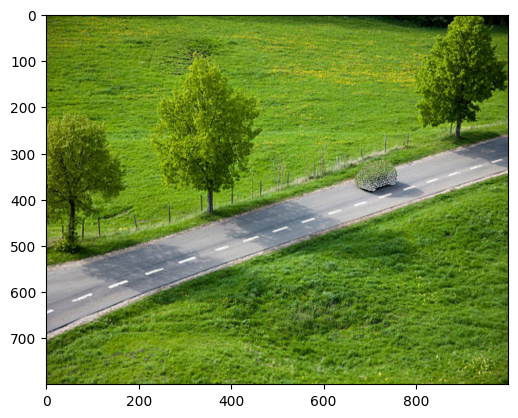

In [20]:
def get_neighboring_pixel(img, x, y):
  x_rand, y_rand = 0,0

  max_num_tries = 30
  max_tries_per_neighbourhood = 5
  neighbourhood_size_increment = 30
  current_window_size = 30
  total_tries = 3
  for _ in range(math.ceil(max_num_tries/max_tries_per_neighbourhood)):
    for _ in range(max_tries_per_neighbourhood):
      min_x = max(0, x-current_window_size)
      max_x = min(800, x+current_window_size)
      min_y = max(0, y-current_window_size)
      max_y = min(1000, y+current_window_size)
      x_rand = random.randint(min_x, max_x-1)
      y_rand = random.randint(min_y, max_y-1)
      total_tries += 1
      if not(img[x_rand][y_rand][0]==0 and img[x_rand][y_rand][1]==0 and img[x_rand][y_rand][2]==0):
          return x_rand, y_rand
    current_window_size += neighbourhood_size_increment

  return x_rand, y_rand

def fill_swath_with_neighboring_pixel(img):
  img_with_neighbor_filled = img.copy()
  (x_swath, y_swath, z_swath) = np.where(img == [255, 255, 255])
  #print((x_swath, y_swath, z_swath))

  for i in range(len(x_swath)):
    x_rand, y_rand = get_neighboring_pixel(img, x_swath[i], y_swath[i])
    img_with_neighbor_filled[x_swath[i]][y_swath[i]] = img[x_rand][y_rand]
  return img_with_neighbor_filled


for i in range(9):

    segmented_obj = fill_swath_with_neighboring_pixel(segmented_obj)

plt.imshow(segmented_obj)

#**CIFAR-10**

In [21]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Custom dataset class to filter and relabel the classes
class AutomobileDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.automobile_classes = [1, 9]  # Class indices for 'car' and 'truck'

        # Create a mapping of original labels to new binary labels
        self.label_map = {label: 1 if label in self.automobile_classes else 0 for label in range(10)}

        # Filter the dataset to include only automobile and non-automobile samples
        self.indices = [i for i, (_, label) in enumerate(dataset) if label in self.automobile_classes or label not in self.automobile_classes]

    def __getitem__(self, index):
        img, label = self.dataset[self.indices[index]]
        label = self.label_map[label]
        return img, label

    def __len__(self):
        return len(self.indices)

# Load the CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create the automobile datasets
trainset_auto = AutomobileDataset(trainset)
testset_auto = AutomobileDataset(testset)

# Create the data loaders
trainloader = torch.utils.data.DataLoader(trainset_auto, batch_size=6, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset_auto, batch_size=6, shuffle=False, num_workers=2)

classes = ('others', 'automobile')

Files already downloaded and verified
Files already downloaded and verified


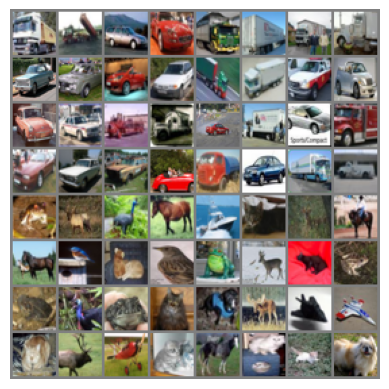

automobile automobile automobile automobile automobile automobile automobile automobile automobile automobile automobile automobile automobile automobile automobile automobile automobile automobile automobile automobile automobile automobile automobile automobile automobile automobile automobile automobile automobile automobile automobile automobile others others others others others others others others others others others others others others others others others others others others others others others others others others others others others others others others


In [22]:
# Function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')  # Remove axis
    plt.show()

# Get a balanced subset of images from the training set
automobile_indices = [i for i, (_, label) in enumerate(trainset_auto) if label == 1]
other_indices = [i for i, (_, label) in enumerate(trainset_auto) if label == 0]

selected_indices = automobile_indices[:32] + other_indices[:32]
selected_dataset = torch.utils.data.Subset(trainset_auto, selected_indices)

# Create a data loader for the selected images
selected_loader = torch.utils.data.DataLoader(selected_dataset, batch_size=64, shuffle=False)

# Get the selected images and labels
images, labels = next(iter(selected_loader))

# Create a grid of images
img_grid = torchvision.utils.make_grid(images, nrow=8)

# Show the grid of images
imshow(img_grid)

# Print the labels
label_names = ['automobile' if label == 1 else 'others' for label in labels]
print(' '.join('%5s' % label_names[j] for j in range(64)))

**CNN**

In [23]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)  # Change the output size to 2

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


In [ ]:
#For Training purpose only (Dont RUN this cell)
num_epochs = 10

for epoch in range(num_epochs):
    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % 100 == 99:
            print(f'[Epoch {epoch+1}, Batch {i+1}] Loss: {running_loss / 100:.3f}')
            running_loss = 0.0

    # Evaluate the model on the test set after each epoch
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Epoch {epoch+1} Accuracy: {accuracy:.2f}%')

print('Finished Training')

[Epoch 1, Batch 100] Loss: 0.606
[Epoch 1, Batch 200] Loss: 0.572
[Epoch 1, Batch 300] Loss: 0.494
[Epoch 1, Batch 400] Loss: 0.448
[Epoch 1, Batch 500] Loss: 0.441
[Epoch 1, Batch 600] Loss: 0.467
[Epoch 1, Batch 700] Loss: 0.406
[Epoch 1, Batch 800] Loss: 0.428
[Epoch 1, Batch 900] Loss: 0.364
[Epoch 1, Batch 1000] Loss: 0.404
[Epoch 1, Batch 1100] Loss: 0.411
[Epoch 1, Batch 1200] Loss: 0.401
[Epoch 1, Batch 1300] Loss: 0.368
[Epoch 1, Batch 1400] Loss: 0.402
[Epoch 1, Batch 1500] Loss: 0.383
[Epoch 1, Batch 1600] Loss: 0.347
[Epoch 1, Batch 1700] Loss: 0.340
[Epoch 1, Batch 1800] Loss: 0.354
[Epoch 1, Batch 1900] Loss: 0.350
[Epoch 1, Batch 2000] Loss: 0.358
[Epoch 1, Batch 2100] Loss: 0.351
[Epoch 1, Batch 2200] Loss: 0.316
[Epoch 1, Batch 2300] Loss: 0.337
[Epoch 1, Batch 2400] Loss: 0.347
[Epoch 1, Batch 2500] Loss: 0.315
[Epoch 1, Batch 2600] Loss: 0.313
[Epoch 1, Batch 2700] Loss: 0.309
[Epoch 1, Batch 2800] Loss: 0.358
[Epoch 1, Batch 2900] Loss: 0.317
[Epoch 1, Batch 3000] L

In [25]:
# Save the trained model
vehicle_model_path = 'saved_models/trained_model.pth'
# torch.save(net.state_dict(), vehicle_model_path)
# print(f'Model saved at: {vehicle_model_path}')

# **Load the model into all masks**

In [26]:
car_detect_network = Net()
car_detect_network.load_state_dict(torch.load(vehicle_model_path))

#test_tensor = torch.rand(3, 32, 32)
#car_detect_network(test_tensor)

<All keys matched successfully>

In [27]:
image_path = './images/Car_8.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (0, 0), fx = 1000/image.shape[1], fy = 800/image.shape[0])

In [28]:
mask_generator = SamAutomaticMaskGenerator(sam)
masks = mask_generator.generate(image)

found car at position 1
found car at position 2
found car at position 6
found car at position 7
found car at position 16
found car at position 24


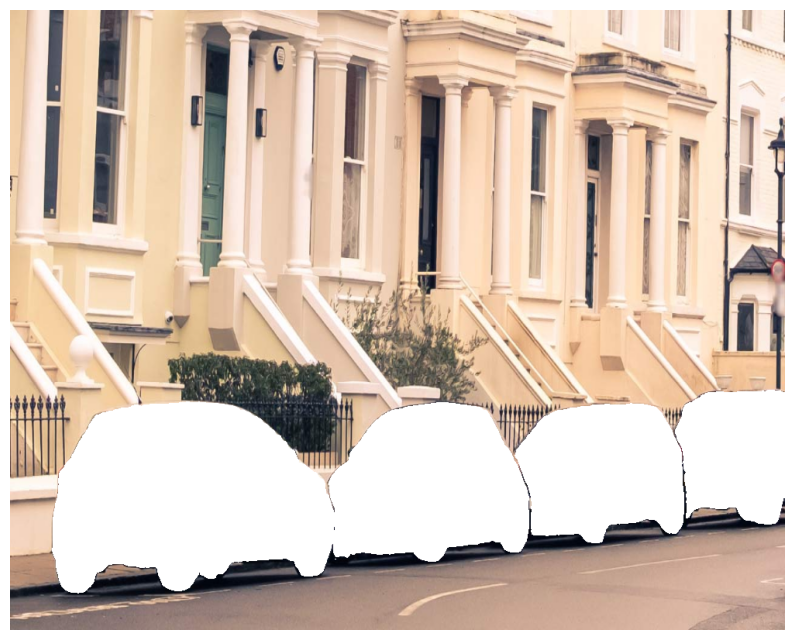

In [29]:
# Define the transformation
transform_resize = transforms.Compose([
    transforms.Resize((32, 32))
])

# Select the car mask automatically

car_masks = []
model_inputs = []
for n, mask in enumerate(masks):
    image_tensor = transform(image)
    bb_x = mask['bbox'][0]
    bb_y = mask['bbox'][1]
    bb_w = mask['bbox'][2]
    bb_h = mask['bbox'][3]
    image_crop = transform_resize(image_tensor[:, bb_y : bb_y + bb_h, bb_x : bb_x + bb_w])

    output = car_detect_network(image_crop)
    _, predicted = torch.max(output.data, 1)
    if predicted.item() == 1:  # Automobile class
        car_masks.append(mask['segmentation'])
        print(f"found car at position {n}")

# Plot the car masks on the source image
if len(car_masks) > 0:
    masked_image = image.copy()
    for car_mask in car_masks:
        masked_image[car_mask] = [255, 255, 255]  # Set the mask pixels to white

    plt.figure(figsize=(10, 10))
    plt.imshow(masked_image)
    plt.axis('off')
    plt.show()
else:
    print("No cars detected in the image.")


In [30]:
def get_neighboring_pixel(img, x, y, window_size=30):
    min_x = max(0, x - window_size)
    max_x = min(img.shape[0], x + window_size + 1)
    min_y = max(0, y - window_size)
    max_y = min(img.shape[1], y + window_size + 1)

    window = img[min_x:max_x, min_y:max_y]
    non_white_pixels = window[np.where(np.any(window != [255, 255, 255], axis=-1))]

    if len(non_white_pixels) > 0:
        random_pixel = non_white_pixels[np.random.choice(len(non_white_pixels))]
        return random_pixel
    else:
        return img[x, y]

def fill_swath_with_neighboring_pixel(img, num_iterations=10):
    img_with_neighbor_filled = img.copy()
    white_mask = np.all(img == [255, 255, 255], axis=-1)

    for _ in range(num_iterations):
        white_indices = np.argwhere(white_mask)
        np.random.shuffle(white_indices)

        for x, y in white_indices:
            neighboring_pixel = get_neighboring_pixel(img_with_neighbor_filled, x, y)
            img_with_neighbor_filled[x, y] = neighboring_pixel

        white_mask = np.all(img_with_neighbor_filled == [255, 255, 255], axis=-1)

        if not np.any(white_mask):
            break

    return img_with_neighbor_filled

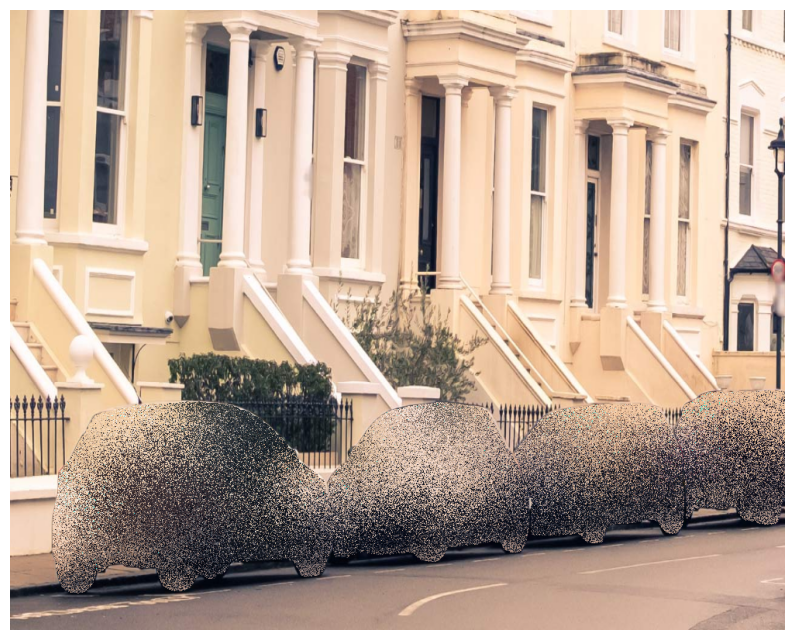

In [31]:
#Apply the missing pixel filler to repair the image for each car mask
if len(car_masks) > 0:
    segmented_obj = image.copy()
    for car_mask in car_masks:
        pixel_list = []
        for i in range(len(image)):
            for j in range(len(image[i])):
                if car_mask[i][j]:
                    pixel_list.append([255, 255, 255])
                else:
                    pixel_list.append(segmented_obj[i][j])

        segmented_obj_car = np.array(pixel_list).reshape(len(image), len(image[0]), 3)

        segmented_obj_car = fill_swath_with_neighboring_pixel(segmented_obj_car, num_iterations=20)

        # Combine the repaired car image with the original image
        segmented_obj = np.where(segmented_obj_car == [255, 255, 255], segmented_obj, segmented_obj_car)

    plt.figure(figsize=(10, 10))
    plt.imshow(segmented_obj)
    plt.axis('off')
    plt.show()
else:
    print("No cars detected in the image.")